In [1]:
pip install --pre dgl-cu101

     |████████████████████████████████| 19.6MB 159kB/s 


In [61]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

0it [00:00, ?it/s]

9920512it [00:00, 11058391.83it/s]                           


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 162064.68it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


1654784it [00:00, 2589877.52it/s]                           
8192it [00:00, 62528.98it/s]            


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw
Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [0]:
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import dgl
import dgl.function as fn


def init_graph(visible_units, hidden_units):
    g0 = dgl.bipartite(
        (np.repeat(np.arange(visible_units), hidden_units),
         np.tile(np.arange(hidden_units), visible_units)),
        'v_unit',
        'v2h',
        'h_unit',
    )
    g1 = dgl.bipartite(
        (np.tile(np.arange(hidden_units), visible_units),
         np.repeat(np.arange(visible_units), hidden_units)),
        'h_unit',
        'h2v',
        'v_unit',
    )
    
    g = dgl.hetero_from_relations([g0, g1])
    return g

In [0]:
class RBM(nn.Module):
    def __init__(self,
        n_vis=784,
        n_hin=500,
        k=5):
        super(RBM, self).__init__()
        self.g = init_graph(n_vis, n_hin)
        self.b = nn.Parameter(th.zeros(n_vis, 1))
        self.g.nodes['v_unit'].data['b'] = self.b
        self.c = nn.Parameter(th.zeros(n_hin, 1))
        self.g.nodes['h_unit'].data['c'] = self.c
        self.W = nn.Parameter(th.zeros(n_vis * n_hin, 1))
        nn.init.xavier_normal_(self.W, gain=1)
        self.g.edges['v2h'].data['w'] = self.W
        self.g.edges['h2v'].data['w'] = self.W
        self.k = k
        self.n_vis = n_vis
        self.n_hin = n_hin
    
    def sample_from_p(self,p):
        return F.relu(torch.sign(p - torch.rand(p.size()).cuda()))
    
    def v_to_h(self, v):
        g = self.g.local_var()
        
        g.nodes['v_unit'].data['v'] = v
        g.multi_update_all({'v2h':(fn.u_mul_e('v','w','m'), fn.sum('m', 'wv'))},
                  'sum')
        
        p_h = torch.sigmoid(self.c+g.nodes['h_unit'].data['wv'])
        sample_h = self.sample_from_p(p_h.T)
        return p_h,sample_h.T
    
    def h_to_v(self,h):
        g = self.g.local_var()
        g.nodes['h_unit'].data['h'] = h
        g.multi_update_all({'h2v': (fn.u_mul_e('h','w','m'), fn.sum('m', 'wh'))},
                  'sum')

        p_v = torch.sigmoid(self.b+g.nodes['v_unit'].data['wh'])
        sample_v = self.sample_from_p(p_v.T)
        return p_v,sample_v.T
        
    def forward(self, v):
        v_ = v.T
        for _ in range(self.k):
            pre_h_,h_ = self.v_to_h(v_)
            pre_v_,v_ = self.h_to_v(h_)
        return v,v_.T
    
    def free_energy(self,v):
        vbias_term = v.mv(self.b.flatten())
        wx_b = F.linear(v,self.W.view(self.n_vis, self.n_hin).T,self.c.flatten())
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

In [0]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

In [0]:
rbm = RBM(k=1)

In [0]:
train_op = optim.SGD(rbm.parameters(),0.1)

In [341]:
rbm.cuda().train()
for epoch in range(20):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = data.view(-1,784)
        sample_data = data.bernoulli().cuda()
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.item())
        train_op.zero_grad()
        loss.backward()
        train_op.step()
    
    print(np.mean(loss_))

-8.064664242872551
-7.039680529759129
-4.914501686340202
-3.3904802855143923
-2.3335311011210687
-1.5784039202529485
-1.1434157641965952
-0.7770525641532849
-0.46103988679995667
-0.24766130589727145
-0.0743582914633029
-0.03372088271671775
0.1554293439332356
0.20915296997851146
0.33493110315123603
0.38951201937091884
0.45274499433635396
0.5100320193813299
0.5355164094774454
0.6481792393015392


In [0]:
import matplotlib.pyplot as plt

def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

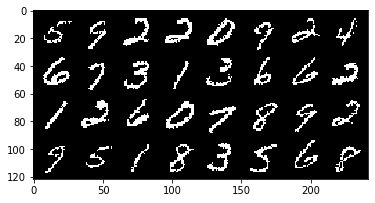

In [343]:
show_adn_save("real",make_grid(v.view(32,1,28,28).cpu()))

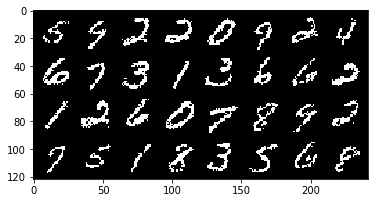

In [344]:
show_adn_save("generate",make_grid(v1.view(32,1,28,28).cpu().detach()))